# 08. Milestone Project: PyTorch Paper Replicating

The goal of machine learning research paper replicating is : turn ML research papers into usable code.

In this notebook we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/abs/2010.11929

## 0. Setup

Let's upload code we've previously written + required libraries

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1458), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 36.42 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [ ]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224 # Table 3 - ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Create a batchsize of 32 (paper uses 4096 but it then takes a lot of compute)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))  # Take the train_dataloader -> convert it into an iterator -> retrieve the next batch (a tuple of images and labels)

# Get a single image and lable from the batch

image, label = image_batch[0], label_batch[0]

# View the image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

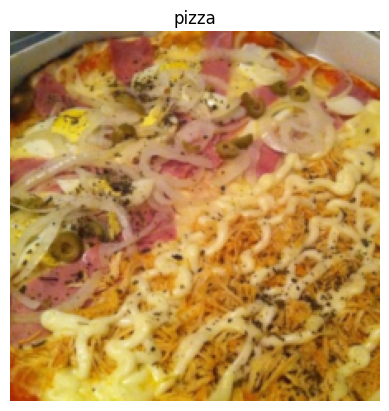

In [ ]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0)); # (color channel, h,w) -> (h,w,color channel)
plt.title(class_names[label]);
plt.axis(False);

## 3. Replicating ViT: Overview

* **Inputs** - What goes into the model? (in our case, image tensor)
* **Outputs** - What comes out of th model/layer/block (in our case, we wnat the model to outpute image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention)
* **Blocks** - A collection of layers
* **Model** - A collection of blocks

### 3.1 ViT overview

* Figure 1: Visual overview of the architecture
* Four exuation: math equations which define the functions of each layer/block
* Table 1/3: Different hyperparameters for the architecture/training.
* Text

### Figure 1

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true)

* **Embedding** - learnable representation (start with random numbers and imporve over time)

* **Residual Connections** - are a type of skip connection (**+**) that learns residual function with reference to the layer inputs, instead of learning unreferenced functions

* **LayerNorm** - normalizes the inputs across the features (channels) for each token independently



### Four equations

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)


For explanation:

#### https://arxiv.org/abs/2010.11929



* **Normalization** means scaling features to a common range so that they contribute equally to the model's output

* **MSA** - Multiheaded self attention

* **MLP** - Multi layer perceptron -> Neural network with x number of layers

### Table 1

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true)

* ViT-Base, ViT-Large, ViT-Huge are all differnet sizes of the sames model architecture.

* Layers - the number of transformer encoder layers

* Hidden size D - the embedding size throughout the architecture of each vector(learnable)

* MLP size - the number of hidden units/neurons in the MLP

* Heads - the number of multi-head self attention


## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

### 4.1 Calculate imput and output shapes by hand
Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224,224,3) -> single image -> (height,width,coloar channels)

* Input shape: H x W x C (from equation 1)

* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H -> Height
* W -> Width
* C -> Color channels
* P -> Patch size
* N = number of patches = (height*width) / p^2
* D = Constant latent vector size = embedding dimension ( see Table 1)

In [ ]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate number of patches
number_of_patches = int((height*width) / patch_size**2)
number_of_patches

196

In [ ]:
# Input shape
embedding_layer_input_shape = (height,width,color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches,patch_size**2 * color_channels)

print(f"Input shape (single 2d image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding dimensions)")

Input shape (single 2d image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding dimensions)


### 4.2 Turining single image into patches


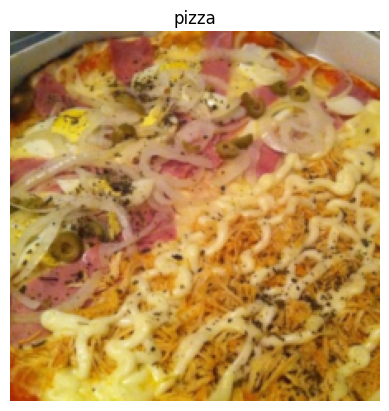

In [ ]:
# VIew a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
image.shape

torch.Size([3, 224, 224])

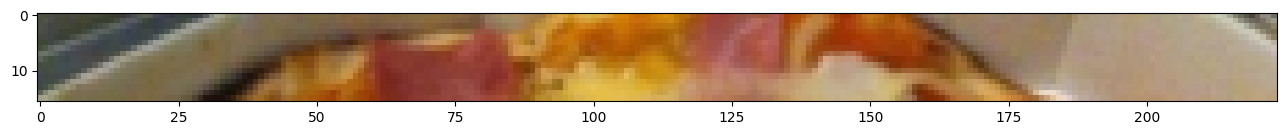

In [ ]:
# Get the top row of the image
image_permuted = image.permute(1,2,0)

# Index to plot the top row of pixels
patch_size = 16 #(16 pixels)
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:]);

Number of patches per row: 14.0
Patch size: 16 pixesl x 16 pixels


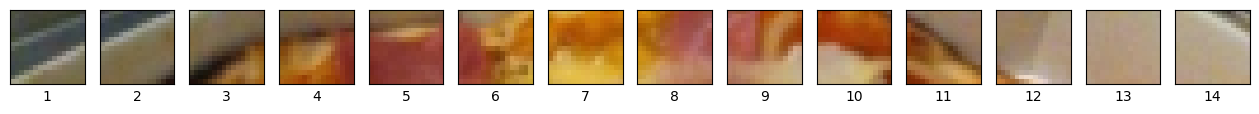

In [ ]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixesl x {patch_size} pixels")

# Create a series of subplots
fig,axs = plt.subplots(nrows=1,
                      ncols=img_size // patch_size, # one column for each patch
                      sharex=True,
                      sharey=True,
                      figsize=(patch_size,patch_size))

# Iterate through number of patches in the top row

for i,patch in enumerate(range(0,img_size,patch_size)):
  axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:]);
  axs[i].set_xlabel(i+1) # Set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0
Patch size: 16 pixels x 16 pixels


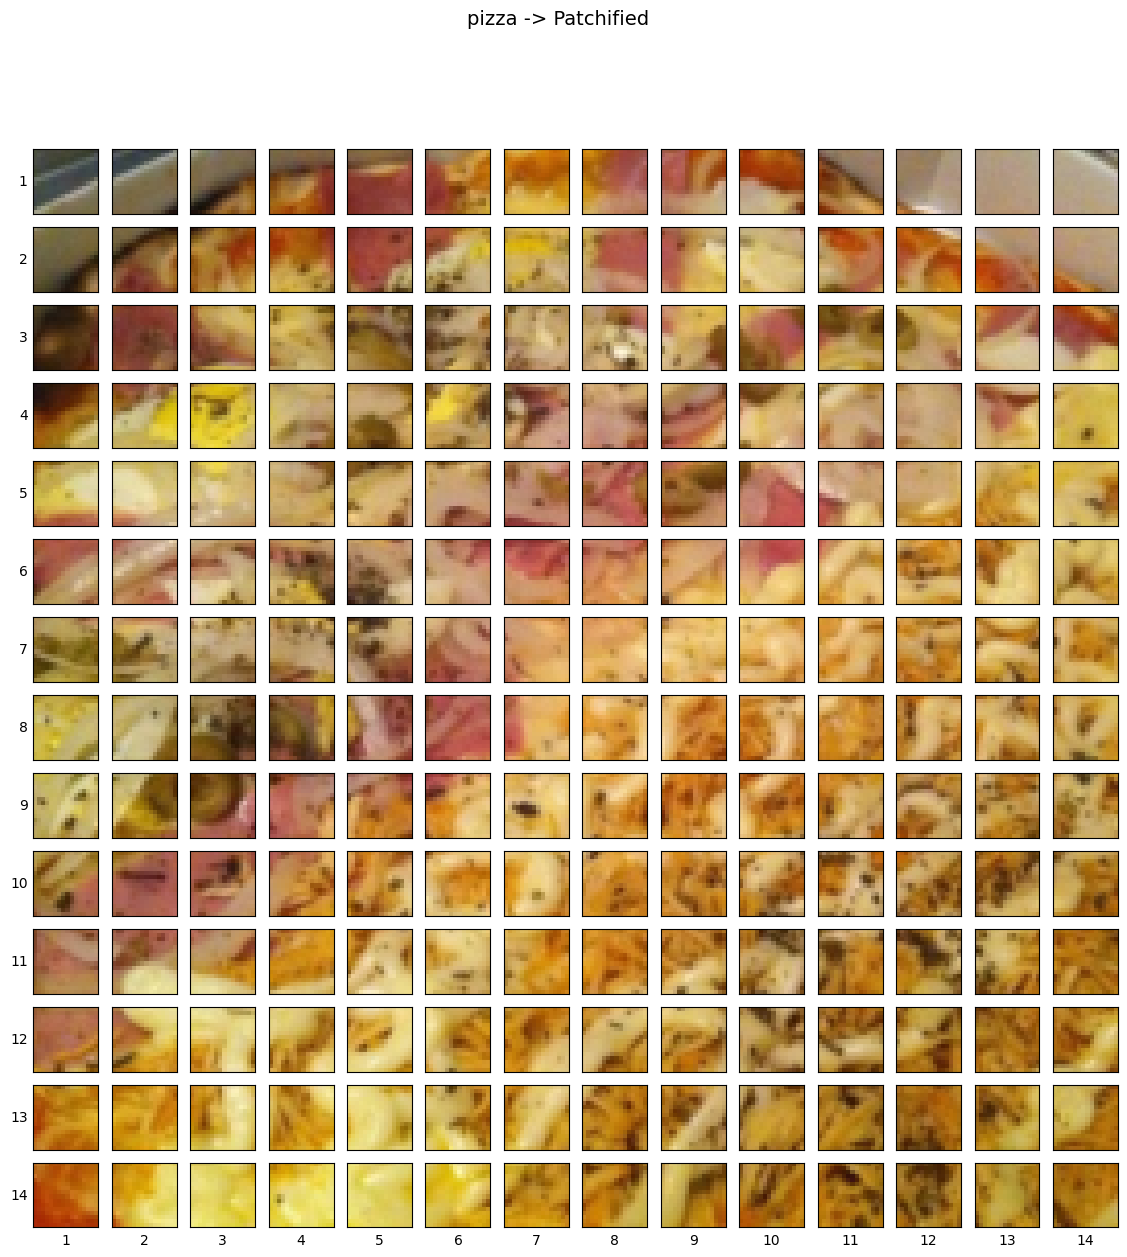

In [ ]:
# Setup code to plot the whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
\nNumber of patches per column: {num_patches}\
\nTotal patches: {num_patches*num_patches}\
\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig,ax = plt.subplots(nrows=img_size // patch_size,
                      ncols=img_size// patch_size,
                      figsize=(num_patches,num_patches),
                      sharex=True,
                      sharey=True)

# Loop thorugh height and width of image
for i,patch_height in enumerate(range(0,img_size,patch_size)):
  for j, patch_width in enumerate(range(0,img_size,patch_size)):
    # Plot the permuted image on the differnet axes
    ax[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,#Iterate thorugh the height
                                  patch_width:patch_width+patch_size, #Iterate through the width
                                  :])
    # Set up lable info for each subplot (patch)
    ax[i,j].set_ylabel(i+1,
                       rotation="horizontal",
                       horizontalalignment="right",
                       verticalalignment="center")
    ax[i,j].set_xlabel(j+1)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    ax[i,j].label_outer()

# Set up title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

 ### 4.3 Creating image patches and turning them into patch embeddings

 We could create the image patches and image patch embeddings in a single step usign `torch.nn.Conv2d()` and settign the kernel size and stride parameters to `patch_size`

In [ ]:
# Create a conv2d laeyr to turn images into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters form the ViT paper
conv2d = nn.Conv2d(in_channels=3, #for color images
                   out_channels=768, # D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

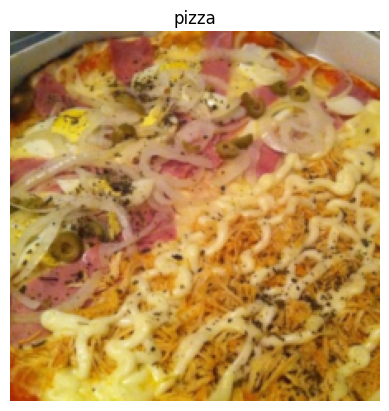

In [ ]:
# View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Pass the image through the convolution layer

image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (b,c,h,w)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer, it's shape is:

```python
torch.Size([1,768,14,14]) -> [batch_size,embedding_dim,feature_map_height,feature_map_width]
```

Showing random convolutional feature maps: [214, 163, 478, 426, 420]


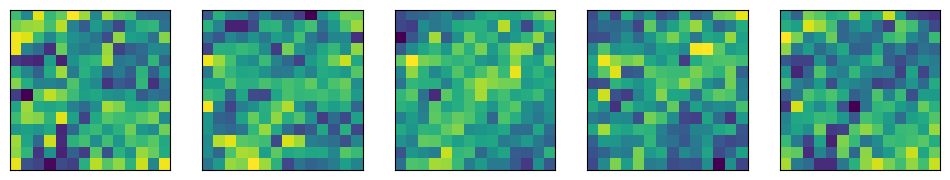

In [ ]:
# Plot random convolution feature map (embedding)

import random
random_indexes = random.sample(range(0,768), k=5)
print(f"Showing random convolutional feature maps: {random_indexes}")

# Create plot
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(12,12))

# Plot random images on feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:,idx,:,:] # index on the output tensor of the conv2d
  ax[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch and to numpy for matplotlib
  ax[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map,single_feature_map.requires_grad

(tensor([[[ 0.1201,  0.0033, -0.0274, -0.0448, -0.0607, -0.1235, -0.0979,
            0.0345, -0.0633, -0.0084, -0.0763,  0.0508,  0.0341,  0.0862],
          [ 0.0498,  0.0507, -0.1710, -0.0456, -0.0191,  0.0117, -0.0527,
           -0.0076, -0.0246, -0.0066, -0.0999, -0.1037, -0.0711,  0.0540],
          [-0.0244, -0.0277, -0.1299,  0.0103, -0.0546, -0.1717,  0.0332,
            0.0538, -0.0581, -0.0291, -0.0365, -0.0236,  0.0759, -0.0902],
          [-0.0252, -0.0178, -0.0714, -0.0445, -0.0345, -0.0443, -0.1001,
            0.0209,  0.0227, -0.0588,  0.0069, -0.0027, -0.1193, -0.0836],
          [-0.0496,  0.0879,  0.0465,  0.0107,  0.1191, -0.1281, -0.0003,
           -0.0295, -0.0382, -0.0902,  0.0724, -0.0390, -0.0144, -0.0106],
          [-0.0113, -0.1032,  0.0556, -0.1131,  0.0080,  0.0216, -0.0014,
           -0.0387, -0.0937, -0.0256, -0.0603, -0.0194,  0.0314, -0.0423],
          [-0.0295, -0.0350, -0.0105,  0.0245, -0.1353, -0.0179,  0.0107,
           -0.0866, -0.0876, -0.

### 4.4 Flattening the patch embedding with `torcn.nn.Flatten()`

Righ now we've got a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of ViT Transformer Encoder

In [ ]:
print(f"{image_out_of_conv.shape} -> (batch_size, embeddin_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embeddin_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [ ]:
from torch import nn

flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map(patches) shape: torch.Size([1, 768, 14, 14])
Flattened feature maps shape: torch.Size([1, 768, 196])
Flattened feature maps shape: torch.Size([1, 768, 196])


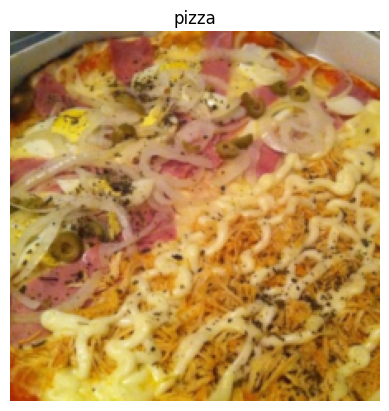

In [ ]:
# Put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map(patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
flattened_feature_maps = flatten_layer(image_out_of_conv)
print(f"Flattened feature maps shape: {flattened_feature_maps.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened feature maps shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Rearrange iutput of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches,embedding_dimensions)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches,embedding_dimensions)


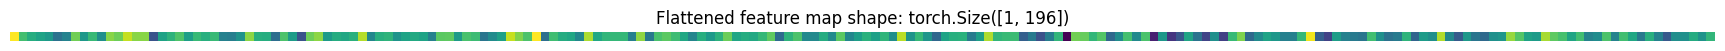

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map =image_out_of_conv_flattened_permuted[:,:,0]

# Plot the flattened map
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Turning the ViT patch embedding layer into a putorch module

1. Create class called `PatchEmbedding` that inherits from `nn.module`
2. Initialize with appropriate hyperparameters, such as channels embedding, dimensions, patch size
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer 3
5. Define a `forward()` that defines a forward computation
6. Make sure the output shapes of layer reflects the required output shape of the patch embedding

In [ ]:
# 1. Create a class
class PatchEmbedding(nn.Module):

  #2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()

    self.patch_size= patch_size

    # 3. Create a layer to turn image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4.Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  def forward(self,x):
    # Createa assertion to check the inputs are the correct shape
    image_resoultion = x.shape[-1]
    assert image_resoultion % patch_size == 0, "Image size must be divisible by patch size"

    # Forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. Make sure returned sequencs embedding dimensions are in the right order (batch_size,number_of_patches,embedding_dim)
    return x_flattened.permute(0,2,1)


In [ ]:
set_seeds()

# Create an instance of patch embedding layer

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # Add extra batch dimension
print(f"Output image size: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output image size: torch.Size([1, 196, 768])


In [ ]:
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor_bad = torch.randn(1,3,250,250)

# patchify(rand_image_tensor_bad)

### 4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding,

In [ ]:
patch_embedded_image

tensor([[[-0.2822,  0.0788, -0.1979,  ...,  0.3563, -0.1261,  0.1565],
         [-0.4704,  0.1913, -0.0641,  ...,  0.2953, -0.2542,  0.2238],
         [-0.4011,  0.0183,  0.0698,  ...,  0.2656, -0.3437,  0.1481],
         ...,
         [-0.3596,  0.0778, -0.1163,  ...,  0.2634, -0.3222,  0.2008],
         [-0.5836,  0.0583, -0.1942,  ...,  0.3501, -0.2689,  0.2586],
         [-0.5488,  0.1195, -0.0725,  ...,  0.3743, -0.2607,  0.1262]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
# Get the batch size and embedding dimesnion
batch_size = patch_embedded_image.shape[0]

embedding_dimension = patch_embedded_image.shape[-1]

batch_size,embedding_dimension

(1, 768)

In [ ]:
# Create class toke enbedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),
                           requires_grad=True)
class_token

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [ ]:
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token,patch_embedded_image),
                                                      dim=1) # Number of patches dimension
print(patch_embedded_image_with_class_embedding)

print(f"Sequence of patch embedding with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size,class_token + number_of_patches,embedding dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2822,  0.0788, -0.1979,  ...,  0.3563, -0.1261,  0.1565],
         [-0.4704,  0.1913, -0.0641,  ...,  0.2953, -0.2542,  0.2238],
         ...,
         [-0.3596,  0.0778, -0.1163,  ...,  0.2634, -0.3222,  0.2008],
         [-0.5836,  0.0583, -0.1942,  ...,  0.3501, -0.2689,  0.2586],
         [-0.5488,  0.1195, -0.0725,  ...,  0.3743, -0.2607,  0.1262]]],
       grad_fn=<CatBackward0>)
Sequence of patch embedding with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size,class_token + number_of_patches,embedding dim)


### 4.7 Creating a position embedding

Want to: Create a series of 1D learnable position embeddings and to add them to sequence of patch embeddings.

In [ ]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimesnions
embedding_dimensions = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimensions),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# View the sequence of patch embedding with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2822,  0.0788, -0.1979,  ...,  0.3563, -0.1261,  0.1565],
          [-0.4704,  0.1913, -0.0641,  ...,  0.2953, -0.2542,  0.2238],
          ...,
          [-0.3596,  0.0778, -0.1163,  ...,  0.2634, -0.3222,  0.2008],
          [-0.5836,  0.0583, -0.1942,  ...,  0.3501, -0.2689,  0.2586],
          [-0.5488,  0.1195, -0.0725,  ...,  0.3743, -0.2607,  0.1262]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7178, 1.0788, 0.8021,  ..., 1.3563, 0.8739, 1.1565],
         [0.5296, 1.1913, 0.9359,  ..., 1.2953, 0.7458, 1.2238],
         ...,
         [0.6404, 1.0778, 0.8837,  ..., 1.2634, 0.6778, 1.2008],
         [0.4164, 1.0583, 0.8058,  ..., 1.3501, 0.7311, 1.2586],
         [0.4512, 1.1195, 0.9275,  ..., 1.3743, 0.7393, 1.1262]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding

Let's see it all in one cell

In [ ]:
set_seeds()

#1. Set the patch size
patch_size = 16

# 2. Print shapes of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height,width = image.shape[1], image.shape[2]

# 3. Get the image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass the input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create a class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimensions),
                          requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_with_class_token = torch.cat((class_token,patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_with_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # It is learnable -> can track gradients and update them with gradient descent

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_with_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")


Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


* **Multi-head Attention (MSA)** is a module for attention mechanisms which runs through an attention mechanism several times in parallel.

* **Read**
1. **https://arxiv.org/pdf/2010.11929**
2. **THE ILLUSTRATED TRANSFORMER**
3. **ATTENTION IS ALL YOU NEED**
  

## Equation 2: Multihead Self-Attention (MSA block)

* MSA : which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation

* To replicate MSA in PyTorch: https://docs.pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

* LayerNorm = Layer normalization is a technique to normalize the distribution of intermediate layers. It enables smoother gradients, faster, training and better generalizaion accuracy
  * Normalization = make everything have the same mean and std deviation
  * In PyTorch - noormalizes values over **D** dimension (in our case), the **D** dimension is the embedding dimension
    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """
  Create a MSA block
  """
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from Table 1 of ViT-Base
               num_heads: int=12, # Heads from Table 1 of ViT-Base
               attn_dropout:int=0):

    super().__init__()
    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create MSA
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)  # (batch,seq,feature) -(batch,num_patchs,embedding_dim)
  def forward(self,x):
    x = self.layer_norm(x)
    attn_output , _ = self.multihead_attn(query=x,
                                          key=x,
                                          value=x,
                                          need_weights=False)

    return attn_output

In [ ]:
# Create an instance of MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)
# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6. Equation 3. Multilayer Perceptro (MLP) block

* **MLP** = The MLP contains tow layers with a GELU non-linearing (ViT paper)
  * MLP = a quite broad term for a block with series of layer(s), layer can be multiple or even only one hidden layer.
  * Layers can mean: fully-connected, dense, liner, feed-forward, all are often similar names for the same thing. In PyTorch they are often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.kears.Dense() `

  * MLP: number of hidden units = MLP size in Table (ViT Paper)

* **GELU**:
https://paperswithcode.com/method/gelu

* **Dropout** - When used, is applied after every dense layer except for the qkv-projection and directly after adding positonal- to patch embeddings.
  * (See table 3 in ViT paper)

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.GELU(),
        nn.Dropout(p=dropout)
    )

  def forward(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    # return slef.mlp(self.layer_norm(x))

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output of MSA Block throught MLP block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


## 7. Creating the transfomrer encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2)
and MLP (equation 3)

And there are residual connection between each block.

* **ENCODER** - turn a sequence into leanable representation
* **DECODER** - go from learnt representation back to some sort of sequence
* **RESIDUAL CONNECTIONS** - add a layers input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:
```python
# Transfomrer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create a custom Transformer Encoder block

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:int=0.1,
               attn_dropout:int=0):

    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    attn_dropout=attn_dropout)

    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self,x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x

In [ ]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo summary
summary(model=transformer_encoder_block,
        input_size=(1,197,768), #(batch_size,number_of_patches,embedding_dimensions)
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder layer with built-in PyTorch layers

https://docs.pytorch.org/docs/stable/generated/torch.nn.Transformer.html

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()

torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embeddin_size
                                                             nhead=12, # heads
                                                             dim_feedforward=3072, # MLP size
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get a summary using torchinfo summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1,197,768), #(batch_size,number_of_patches,embedding_dimensions)
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## 8. Putting it all together to create ViT


In [ ]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
              img_size:int=224,
              in_channels:int=3,
              patch_size:int=16,
              num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
              embedding_dim:int=768,
              mlp_size:int=3072,
              num_heads:int=12,
              attn_dropout:int=0,
              mlp_dropout:int=0.1,
              embedding_dropout:int=0.1, # Dropout for patch and position embeddings
              num_classes:int=1000):

    super().__init__()

    # Make an assertion that image size is compatible with patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size"

    # Calculate the number of patches (height * width/patch^2)
    self.num_patches = (img_size*img_size) // patch_size**2

    # Create learnable class embedding (needs to go at the front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                        requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim))

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create the transformer encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self,x):
    # Get batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size,-1,-1) # "-1" means to infer the dimensions

    # Create patch embedding
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding
    x = torch.cat((class_token,x),dim=1)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropout to patch embeddings
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder
    x = self.transformer_encoder(x)

    # Put 0th inex logit through classifier
    x = self.classifier(x[:,0])

    return x


In [ ]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(class_token_embedding_single.shape)
print(class_token_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [ ]:
# vit = ViT()
# vit

In [ ]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1,3,224,224) # (batch_size,color_channels,h,w,)

# Create and instance of ViT with the number of classes we're working with (pizza,steak,sushi)
vit = ViT(num_classes=1000)

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 1.8778e-01,  1.2287e+00,  1.1501e+00, -7.3298e-02, -6.8960e-01,
          2.2407e-01, -5.2673e-01,  1.9171e-01, -3.8699e-01,  2.8464e-01,
          1.5707e-01,  5.1449e-01, -6.8738e-01, -1.2771e-01, -1.0805e+00,
         -4.2198e-01, -4.4758e-01, -1.3570e+00,  5.6835e-01,  3.2900e-01,
          3.1847e-01,  6.5212e-01,  1.0999e-01, -7.5035e-01,  7.5619e-01,
         -7.3803e-02,  2.7646e-01,  3.1066e-01, -2.4901e-01, -2.8700e-01,
         -2.4950e-01, -2.3607e-01,  2.9319e-01,  3.3661e-01,  2.6885e-01,
         -3.8156e-01, -2.1526e-02, -1.2144e-02, -8.1443e-01,  1.4403e-01,
         -9.8562e-01, -7.4074e-01, -3.1504e-01, -6.8240e-01, -2.0258e-01,
         -3.2321e-01, -8.2482e-02, -5.4298e-01,  7.1794e-01,  1.4759e-01,
         -7.6212e-01, -3.8919e-01,  9.3851e-01,  9.2401e-02,  4.2810e-01,
         -1.0528e+00,  4.0070e-02, -1.6755e-01, -1.2143e+00,  5.4315e-01,
          3.5367e-03, -3.9820e-02, -2.6275e-01, -1.0777e+00,  2.0163e-01,
         -4.9501e-01, -7.8552e-01,  6.

### 8.1 Getting a visual summary of our ViT model

In [ ]:
from torchinfo import summary

# Get a summary using torchinfo summary
summary(model=ViT(num_classes=len(class_names)),
        input_size=(1,3,224,224), #(batch_sizecolor_channel, height, width)
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training code for our custom ViT

We've replicated the ViT architecture, now let's see how it performs on our FoodVison mini data set

### 9.1 Create an optimizer

The paper states it used Adam optimizer
with B1 value of 0.9 and B2 valuse of 0.999 (Beta value) and a weight decay of 0.1

**Weight decay** - is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

**Regularization technique** - Prevents overfitting

### 9.2 Creating a loss function

The ViT paper doesn't actually mention what loss function they used.

So since it's a multi-class classification we'll use the `torch.nn.CrossEntropyLoss()`

### 9.3 Training our ViT model

In [ ]:
from going_modular.going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3, # 0.001
                             betas=(0.9,0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

result = engine.train(model=vit,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      epochs=10,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0515 | train_acc: 0.3867 | test_loss: 1.1617 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.2046 | train_acc: 0.3164 | test_loss: 2.6372 | test_acc: 0.2604
Epoch: 3 | train_loss: 2.0552 | train_acc: 0.3359 | test_loss: 1.0795 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.5923 | train_acc: 0.2734 | test_loss: 1.2130 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.2771 | train_acc: 0.3086 | test_loss: 1.1210 | test_acc: 0.3504
Epoch: 6 | train_loss: 1.2102 | train_acc: 0.4453 | test_loss: 1.5326 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.4229 | train_acc: 0.2695 | test_loss: 1.3650 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.2903 | train_acc: 0.4297 | test_loss: 1.5648 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1912 | train_acc: 0.4258 | test_loss: 1.1190 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4020 | train_acc: 0.2500 | test_loss: 1.4301 | test_acc: 0.2604


### 9.4 What our trining setup is missing

How our training setup is different to the ViT paper?

We've replicated model architecture correctly.

But what was different between our training procedure (to get such poor results) and the ViT paper training procedure to get such great results?

The main thing our training implementation is missing:

Prevent underfitting
* Data - our setup uses far less data (225, millions)

Prevent overfitting:
* Learning rate warmup - start with a low learning rate and increase to a base LR
* Learning rate deacy - as your model gets closer to convergence, start to lower the learning rate
* Gradient clipping - prevents gradients from getting too big

Search "pytorch [technique name]"

### 9.5 Plotting loss curves for our model

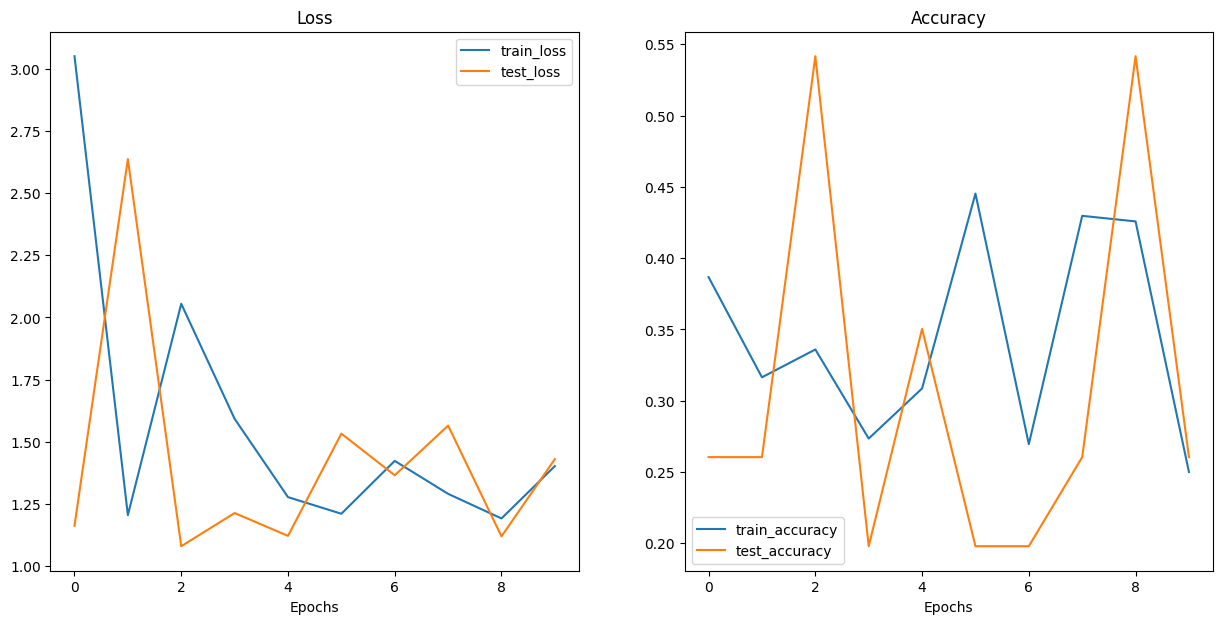

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(result)

## 10. Use a pretrained ViT from `torchvision.models `

Generally, in deep learning if you can use a pretrained model from a larger dataset on your own problem, it's often a good place to start.

If you can find a pretrained model, and use transfer learning, give it a go, it often achieves great results with little data.

### 10.1 Why use a pretrained model

* Sometimes data is limited
* Limited training resources
* Get better reults faster (sometimes)..

In [ ]:
import torch
import torchvision

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 10.2 Prepare a pretrained ViT for use with FoodVision mini (turn it into a feature extractor)

In [ ]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT  # DEFAULT -> Best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 64.4MB/s]


In [ ]:
from torchinfo import summary

# Get a summary using torchinfo summary
summary(model=pretrained_vit,
        input_size=(1,3,224,224), #(batch_sizecolor_channel, height, width)
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for pretrained ViT model

When using a pretrained model, we have to make sure data is formatted in the same way the model was trained on.


In [ ]:
# Get automatic transform from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) # Could use a higher batchsize as we are using a pretrained model

### 10.4 Train feature extractor ViT model

In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plot the loss curves of our pretrained ViT feature extractor model

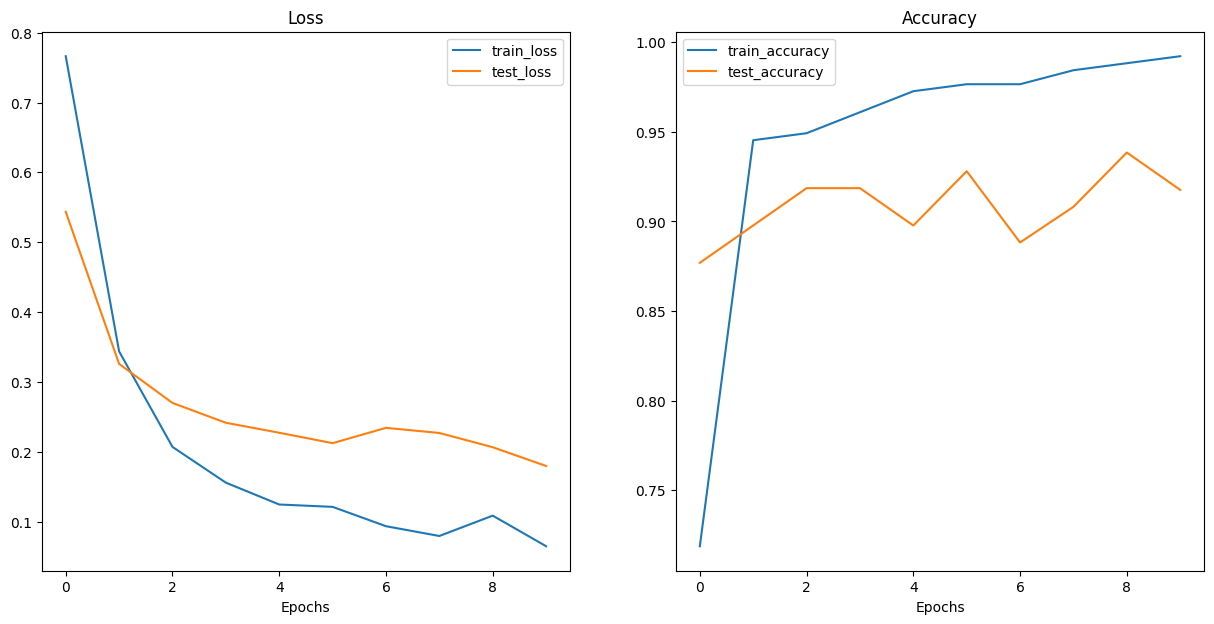

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best preforming ViT model

Now we've got a model the performe quite well, let's save it to a file and check it's filesize.

We want to check the filesize because if we wanted to deploy a model to say website/mobile application, there may be limitation on the size of the model we can deploy.

Eg. a smaller model may be required due to compute restrictions.

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizz_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizz_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("/content/models/08_pretrained_vit_feature_extractor_pizz_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained Vit feature extractor model size: 327 MB


Our pretrained ViT gets some of the best resuts we've seen so far in FoodVision mini, however the model size is 11x larger that our next best model.

Perhaps the larger model size might cause issues when we go to deploy it. (eg. hard to deploy such a large file/might not make predictions as fast as a small model).

## 11. Predicting on a custom image

data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


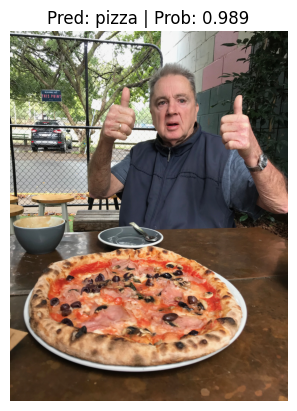

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)